# import

In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import os

from gensim.models import FastText
from tensorflow import keras
from tensorflow.keras import layers, metrics, callbacks, optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import import_ipynb
from module import Pipeline as pl
from module import korean_tokenizers as kt
from module import Custom_Functions as cf
from module import Word_Embedding

2022-10-25 18:59:59.747516: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


importing Jupyter notebook from /home/faraway/ft_classifier/module/Pipeline.ipynb
importing Jupyter notebook from /home/faraway/ft_classifier/module/korean_tokenizers.ipynb
importing Jupyter notebook from /home/faraway/ft_classifier/module/Custom_Functions.ipynb
importing Jupyter notebook from /home/faraway/ft_classifier/module/Word_Embedding.ipynb


# Global

In [2]:
best_model_path = 'models/improve_best.h5'

custom_tokenizer = kt.word_cjs_tokenizer

# Preprocess

In [3]:
def split_Xy(text) :
    text_split = text.split('|')
    X, y = text_split[0], text_split[-1]
    X = X.strip()
    y = y.strip()
    return X, y

with open("Curse-detection-data/dataset.txt", "r") as f :
    pre_data = list(map(split_Xy, f.readlines()))
    
pre_data_np = np.array(pre_data)
pre_data_np

array([['좌배 까는건 ㅇㅂ', '1'],
       ['집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ', '0'],
       ['개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아', '1'],
       ...,
       ['너가 한 말 중에', '0'],
       ['제갈대중 ㅇㅂ', '0'],
       ['우리나라교회는 악마들이모여 주뎅이 처벌리고', '1']], dtype='<U1000')

In [4]:
np.random.shuffle(pre_data_np)

train_data = pre_data_np[:3500]
valid_data = pre_data_np[3500:4500]
test_data = pre_data_np[4500:]

len(train_data), len(valid_data), len(test_data)

(3500, 1000, 1325)

In [5]:
train_X, train_y = train_data[:, 0], train_data[:, 1].astype(np.int16)
valid_X, valid_y = valid_data[:, 0], valid_data[:, 1].astype(np.int16)
test_X, test_y = test_data[:, 0], test_data[:, 1].astype(np.int16)

In [6]:
tokenized_train_X = pl.tokenization(train_X, custom_tokenizer)
tokenized_valid_X = pl.tokenization(valid_X, custom_tokenizer)
tokenized_test_X = pl.tokenization(test_X, custom_tokenizer)

# FastText

In [7]:
ft = FastText(
    sentences = tokenized_train_X,
    vector_size = 100, 
    window = 4, 
    min_count = 3, 
    workers = 2, 
    alpha = 0.1, min_alpha = 0.001, 
    min_n = 1, max_n = 6, 
    sg = 1, 
    epochs= 25)

In [8]:
ft.wv.most_similar('ㅇㅏ')

[('ㅇㅏㄶㅇㅏ*', 0.8256592750549316),
 ('ㅇㅏ*', 0.8045228719711304),
 ('ㅇㅏㄴ', 0.8002992272377014),
 ('ㅇㅏ*ㅇㅖ*', 0.74905925989151),
 ('ㅇㅏ*ㅁㅏ*', 0.715155839920044),
 ('ㅇㅏㄹㅂㅏ*', 0.706531286239624),
 ('ㅇㅏㅍㅊㅏ*', 0.7005673050880432),
 ('ㅇㅏ*ㅁㅔㄴ', 0.6775949597358704),
 ('ㅇㅏ*ㅂㅔ*', 0.6686936616897583),
 ('ㅇㅏ*ㅇㅣ*ㅋㅠ*', 0.655177652835846)]

In [9]:
ft.wv.vectors_vocab.shape

(1102, 100)

In [10]:
tokenizer_tf, embedding_weights = Word_Embedding.make_embedding_models(
                                        tokenized_texts = tokenized_train_X,
                                        fasttext = ft
                                        )

In [11]:
len(tokenizer_tf.word_index)

16872

In [12]:
max_len = 0
for X in tokenized_train_X :
  if len(X) > max_len :
    max_len = len(X)

print(max_len)

MAX_LEN = 250

191


In [13]:
int_train_X = pl.texts_to_int(tokenized_train_X, tokenizer_tf, max_len = MAX_LEN)
int_valid_X = pl.texts_to_int(tokenized_valid_X, tokenizer_tf, max_len = MAX_LEN)
int_test_X = pl.texts_to_int(tokenized_test_X, tokenizer_tf, max_len = MAX_LEN)

int_train_X.shape, int_valid_X.shape, int_test_X.shape

((3500, 250), (1000, 250), (1325, 250))

# Sequential

In [14]:
# BiLSTM
dnn = keras.Sequential([
    layers.Input(shape=(MAX_LEN, )),
    layers.Embedding(len(tokenizer_tf.word_index) + 1, ft.vector_size,
                     weights = [embedding_weights], trainable = False,
                    #  mask_zero= True      # 버전에 따른 이슈 있음
                     ),                     # OP_REQUIRES failed at cudnn_rnn_ops.cc:1517 : Unknown: CUDNN_STATUS_BAD_PARAM
    layers.Masking(mask_value=0),
    layers.Bidirectional(layers.LSTM(units = ft.vector_size, return_sequences=True)),
    layers.Conv1D(ft.vector_size, 4, activation = 'relu', padding = "same"),
    layers.Dropout(0.5),
    layers.Bidirectional(layers.LSTM(units = ft.vector_size, return_sequences=False)),
    layers.Dense(1, activation = 'sigmoid')
])

dnn.summary()

dnn.compile(
    loss = cf.focal_loss(),     # 버전에 따라 tf.keras.losses.BinaryFocalCrossentropy()
    optimizer = optimizers.Nadam(), 
    metrics = [ metrics.Recall(thresholds = 0.5), metrics.Precision(thresholds = 0.5), cf.f1_score, "acc"]
    )

2022-10-25 18:39:50.987910: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-10-25 18:39:51.347568: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:968] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-25 18:39:51.347635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 Ti computeCapability: 7.5
coreClock: 1.485GHz coreCount: 16 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 178.84GiB/s
2022-10-25 18:39:51.347678: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-10-25 18:39:51.349098: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-10-25 18:39:51.350560: I tensorflow/stream_exec

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          1687300   
_________________________________________________________________
masking (Masking)            (None, 250, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 200)          160800    
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 100)          80100     
_________________________________________________________________
dropout (Dropout)            (None, 250, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [15]:
# Keras 모델 콜백
cp = callbacks.ModelCheckpoint(best_model_path,             # file명을 지정합니다
                               monitor='val_f1_score',   # val_f1_score 값이 개선되었을때 호출됩니다
                               verbose=1,            # 로그를 출력합니다
                               save_best_only=True,  # 가장 best 값만 저장합니다
                               mode='max'           # auto는 알아서 best를 찾습니다. min/max
                               )
es = callbacks.EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=7)

callback_list = [cp, es]

history = dnn.fit(int_train_X, train_y,
                  epochs=100, 
                  validation_data=(int_valid_X, valid_y),
                  batch_size = 128, 
                  callbacks = callback_list)

Epoch 1/100


2022-10-25 18:40:02.150961: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-10-25 18:40:02.880009: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


28/28 [==============================] - ETA: 0s - loss: 0.0649 - recall: 0.0137 - precision: 0.5484 - f1_score: 0.0146 - acc: 0.6463
Epoch 00001: val_f1_score improved from -inf to 0.00714, saving model to models/improve_best.h5
28/28 [==============================] - 10s 351ms/step - loss: 0.0649 - recall: 0.0137 - precision: 0.5484 - f1_score: 0.0146 - acc: 0.6463 - val_loss: 0.0622 - val_recall: 0.0029 - val_precision: 1.0000 - val_f1_score: 0.0071 - val_acc: 0.6520
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.0616 - recall: 0.0435 - precision: 0.7826 - f1_score: 0.0749 - acc: 0.6566
Epoch 00002: val_f1_score improved from 0.00714 to 0.14628, saving model to models/improve_best.h5
28/28 [==============================] - 8s 285ms/step - loss: 0.0616 - recall: 0.0435 - precision: 0.7826 - f1_score: 0.0749 - acc: 0.6566 - val_loss: 0.0605 - val_recall: 0.0831 - val_precision: 0.9062 - val_f1_score: 0.1463 - val_acc: 0.6770
Epoch 3/100
28/28 [===============

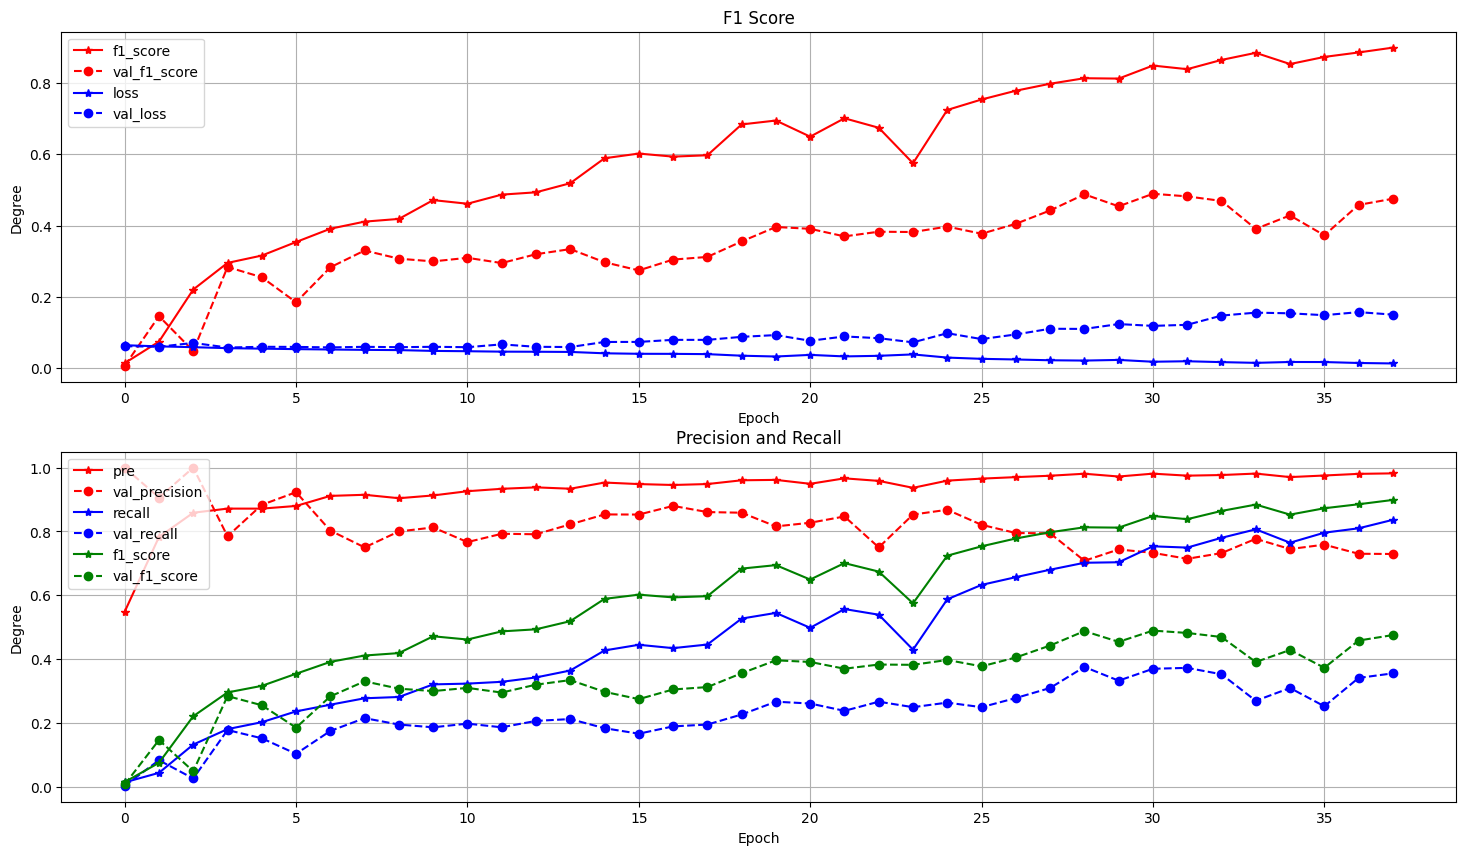

In [16]:
plt.figure(figsize = (18, 10))

plt.subplot(211)
plt.plot(history.history['f1_score'], color = 'red', marker = '*')
plt.plot(history.history['val_f1_score'], color = 'red', linestyle = '--', marker = 'o')
plt.plot(history.history['loss'], color = 'blue', marker = '*')
plt.plot(history.history['val_loss'], color = 'blue', linestyle = '--', marker = 'o')

plt.grid(True)
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Degree')
plt.legend(['f1_score', 'val_f1_score', 'loss', 'val_loss'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['precision'], color = 'red', marker = '*')
plt.plot(history.history['val_precision'], color = 'red', linestyle = '--', marker = 'o')
plt.plot(history.history['recall'], color = 'blue', marker = '*')
plt.plot(history.history['val_recall'], color = 'blue', linestyle = '--', marker = 'o')
plt.plot(history.history['f1_score'], color = 'green', marker = '*')
plt.plot(history.history['val_f1_score'], color = 'green', linestyle = '--', marker = 'o')

plt.grid(True)
plt.title('Precision and Recall')
plt.xlabel('Epoch')
plt.ylabel('Degree')
plt.legend(['pre', 'val_precision', 'recall', 'val_recall', "f1_score", "val_f1_score"], loc='upper left')

plt.show()

In [17]:
model = keras.models.load_model(best_model_path, 
                                     custom_objects={
                                         'focal_loss_fixed': cf.focal_loss(), 
                                         'f1_score' : cf.f1_score
                                         }
                                     )

model.evaluate(int_test_X, test_y)

42/42 [==============================] - 2s 44ms/step - loss: 0.1172 - recall: 0.3634 - precision: 0.6962 - f1_score: 0.4657 - acc: 0.7275


[0.11722300201654434,
 0.36343613266944885,
 0.6962025165557861,
 0.4657045900821686,
 0.7275471687316895]

In [18]:
predict = model.predict(int_test_X)
pred_with_threshold = np.where(predict > 0.4, 1, 0)   # 예상치가 0.4를 넘으면 1, 아니면 0

print(classification_report(test_y, pred_with_threshold))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80       871
           1       0.62      0.43      0.50       454

    accuracy                           0.71      1325
   macro avg       0.68      0.64      0.65      1325
weighted avg       0.70      0.71      0.70      1325

